Based on work from [Matthew Nour](https://matthewnour.com), I have become interested in the trajectories through semantic meaning space for natural language. Particularly demonstrated in his paper [Trajectories through semantic spaces in schizophrenia and the relationship to ripple bursts](https://www.pnas.org/doi/10.1073/pnas.2305290120). 

Here I go through the required code to make a much more basic version of this type of analysis (to demonstrate to myself that I understand how to use semantic embeedings that from natural langugae models).

I used [this](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) tutorial to implement the tokeniser and the BERT model to get the semantic embeddings. 

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
# PCA libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Load model directly
import torch
device = torch.device("mps")
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)


In [3]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

# Now you can use the tokenizer to encode text with the new special tokens
text = "This is an example with a special token <SPECIAL1>."
encoded = tokenizer.encode(text)
decoded = tokenizer.decode(encoded)

print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")


Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Encoded: [101, 2023, 2003, 2019, 2742, 2007, 1037, 2569, 19204, 1026, 2569, 2487, 1028, 1012, 102]
Decoded: [CLS] this is an example with a special token < special1 >. [SEP]


In [16]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "Wikipedia's purpose is to benefit readers by presenting information on all branches of knowledge. Hosted by the Wikimedia Foundation, it consists of freely editable content, whose articles also have numerous links to guide readers towards more information.\
    Written collaboratively by largely anonymous volunteers known as Wikipedians, Wikipedia articles can be edited by anyone with Internet access, except in limited cases where editing is restricted to prevent disruption or vandalism. Since its creation on January 15, 2001, it has grown into the world's largest reference website, attracting over a billion visitors monthly. Wikipedia currently has more than sixty-three million articles in more than 300 languages, including 6,850,354 articles in English, with 114,409 active contributors in the past month.\
    Wikipedia's fundamental principles are summarized in its five pillars. The Wikipedia community has developed many policies and guidelines, although editors do not need to be familiar with them before contributing."
# Source of the text https://en.wikipedia.org/wiki/Wikipedia:About 
# Tokenize the text
tokenized_text = tokenizer.encode(text, add_special_tokens=True)
marked_text = tokenizer.decode(tokenized_text)

# Print out the marked text
marked_text

"[CLS] wikipedia's purpose is to benefit readers by presenting information on all branches of knowledge. hosted by the wikimedia foundation, it consists of freely editable content, whose articles also have numerous links to guide readers towards more information. written collaboratively by largely anonymous volunteers known as wikipedians, wikipedia articles can be edited by anyone with internet access, except in limited cases where editing is restricted to prevent disruption or vandalism. since its creation on january 15, 2001, it has grown into the world's largest reference website, attracting over a billion visitors monthly. wikipedia currently has more than sixty - three million articles in more than 300 languages, including 6, 850, 354 articles in english, with 114, 409 active contributors in the past month. wikipedia's fundamental principles are summarized in its five pillars. the wikipedia community has developed many policies and guidelines, although editors do not need to be f

In [17]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))


[CLS]           101
wikipedia    16,948
'             1,005
s             1,055
purpose       3,800
is            2,003
to            2,000
benefit       5,770
readers       8,141
by            2,011
presenting   10,886
information   2,592
on            2,006
all           2,035
branches      5,628
of            1,997
knowledge     3,716
.             1,012
hosted        4,354
by            2,011
the           1,996
wi           15,536
##kim        21,138
##ed          2,098
##ia          2,401
foundation    3,192
,             1,010
it            2,009
consists      3,774
of            1,997
freely       10,350
edit         10,086
##able        3,085
content       4,180
,             1,010
whose         3,005
articles      4,790
also          2,036
have          2,031
numerous      3,365
links         6,971
to            2,000
guide         5,009
readers       8,141
towards       2,875
more          2,062
information   2,592
.             1,012
written       2,517
collaborative 12,317

In [18]:
# Model is trained on sentence and sentence pairs. so the input needs to be sentence or sentence pairs.

# Mark each of the 22 tokens as belonging to sentence "1".
# This is for one sentence
segments_ids = [1] * len(tokenized_text)

print(segments_ids)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [19]:
# Convert inputs to PyTorch tensors
tokens_tensor    = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
tokens_tensor.shape

torch.Size([1, 189])

In [20]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [21]:
# with torch.no_grad():
#     wordembeddings = outputs.last_hidden_state
    

# Generate embeddings using BERT model
with torch.no_grad():
	outputs = model(tokens_tensor, segments_tensors)
	hidden_states = outputs
	# word_embeddings = 

# Output the shape of word embeddings
# print(f"Shape of Word Embeddings: {word_embeddings.shape}")
hidden_states.last_hidden_state.shape

torch.Size([1, 189, 768])

Now for convience, I am going to put the words and their corresponding vectors into a table using a pandas dataframe

In [22]:
# For each token word, vector pair
embedding_dict = {}
for word, vector in zip(marked_text.split(" "), hidden_states.last_hidden_state[0]):
    embedding_dict[word] = vector

embedding_dict = pd.DataFrame(embedding_dict)
    

Here it is!

In [23]:
embedding_dict

,[CLS],wikipedia's,purpose,is,to,benefit,readers,by,presenting,information,...,although,editors,do,not,need,familiar,them,before,contributing.,[SEP]
0,-0.397800,0.225758,-0.216066,0.181724,-0.548865,-0.476328,-0.187053,0.327365,0.021675,0.026138,...,-0.463596,0.326398,-0.296987,-0.249625,0.021006,-1.213159,-0.253932,-0.900819,0.783844,1.167579
1,0.170911,-0.398236,-0.105627,0.584359,-0.302917,0.331164,0.303018,0.716316,0.444830,0.641611,...,0.180648,0.349346,0.121220,-0.376064,-0.166359,-0.399527,-0.701908,-0.698676,0.144448,0.624116
2,-0.407462,0.499899,0.240278,0.510616,0.623764,0.183634,0.364873,0.250772,1.127726,-0.114914,...,0.406162,0.404217,0.172939,0.466160,0.511995,0.033170,-0.047894,-0.308427,-0.287521,0.112691
3,0.120987,-0.609629,-0.559944,-0.017765,-0.101877,-0.391126,0.335346,-0.113088,0.139200,-0.179634,...,-0.306918,-0.289880,-0.302768,-0.239914,-0.123906,0.114429,0.511084,-0.473308,0.306821,-0.123258
4,-0.333791,-0.200983,-0.451513,0.486447,-0.030032,0.181724,0.465903,-0.647177,0.083822,-0.200970,...,-0.360363,-0.306351,-0.269635,0.295733,-0.080058,0.246851,0.131162,-0.036426,-0.169029,-0.060356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-0.258199,0.958463,-0.121484,0.079637,-0.564082,0.262332,-0.668383,-0.263841,-0.074577,-0.483026,...,-0.040582,-0.376516,-0.050971,0.854265,-0.172597,-0.265581,-0.099148,0.094765,-0.592551,-0.996676
764,-0.155529,0.413391,0.373446,-0.071976,-0.211906,0.460308,0.277623,-0.627632,0.622187,0.092060,...,0.413279,0.135485,0.302015,-0.061225,0.140509,-0.230951,-0.088816,-0.148471,-0.005205,-0.088604
765,-0.085188,0.027113,0.437014,-0.187558,-0.299858,0.092524,-0.260553,-0.045953,-0.553185,0.215945,...,0.167228,0.209997,-0.126639,-0.028156,-0.118846,-0.522136,0.081270,-0.387698,0.275690,0.131839
766,0.646723,0.451272,0.320475,-0.405532,0.323747,0.029601,0.372685,0.031079,0.340696,0.257735,...,-0.221704,-0.137952,0.445956,0.071810,-0.147727,0.250231,0.636241,0.272613,-0.542538,0.278729


For plotting, we can't plot 768 dimensions, so we will reduce the dimensions to 2 using PCA. The dimensions we are going to use are the first two dimensions of the PCA. This will change for the particular set of text that is being analyzed.

In [24]:
# PCA to reduce the dimensionality of the flow_dataframe to 2D
pca = PCA(n_components=2)
pca.fit_transform(embedding_dict.T)
pca.components_.shape, embedding_dict.shape

# Project the flow_dataframe to the 2D PC space using the PCA components
output = embedding_dict.T @ pca.components_.T


output.T


,[CLS],wikipedia's,purpose,is,to,benefit,readers,by,presenting,information,...,although,editors,do,not,need,familiar,them,before,contributing.,[SEP]
0,-0.738609,0.135391,-0.460528,-2.991425,-0.811570,0.073405,7.045363,-2.053942,-5.218218,-0.179280,...,1.233771,1.876566,6.532729,2.686400,1.114694,1.714168,1.446539,0.978354,-0.590626,-9.598780
1,0.410755,6.602470,0.050615,-3.725148,2.182217,-1.167463,-3.344800,-2.576366,1.447452,-1.652778,...,2.879586,3.578430,2.824045,3.603118,4.511847,3.351452,4.518424,3.172381,0.603879,5.161048


Here is the plot of the words in the semantic space and their flow through the meaning space. 

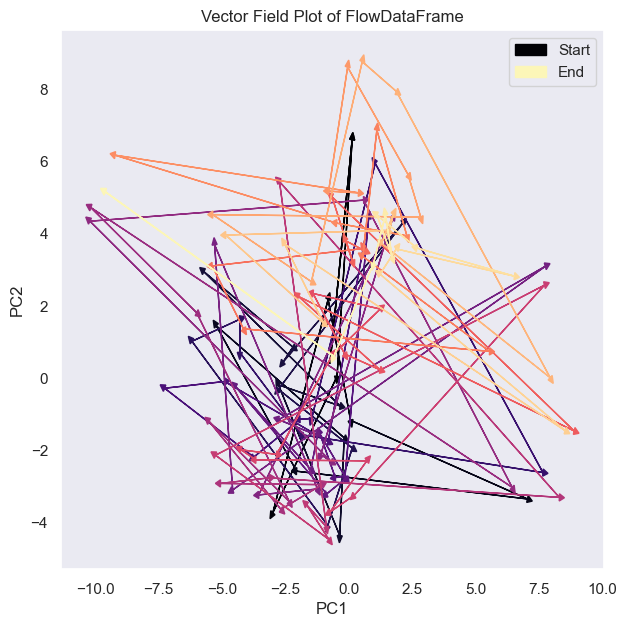

In [36]:
# Plot the flow_dataframe in a vector field plot
s = 7
plt.figure(figsize=(s, s))
# remove the grid
plt.grid(False)
plt.title("Vector Field Plot of FlowDataFrame")

cmap = plt.get_cmap('magma')

# Plot arrows
for index in range(0,output.T.shape[1]-1):
    color = cmap(index/output.T.shape[1])
    # Add label to the color of the first and last arrow
    if index == 0:
        plt.arrow(output.iloc[index, 0],
                  output.iloc[index, 1],
                  output.iloc[index+1, 0] - output.iloc[index, 0],
                  output.iloc[index+1, 1] - output.iloc[index, 1],
                  head_width =0.2, 
                  head_length=0.2, 
                  fc=color, 
                  ec=color,
                  label="Start"
                  )
    elif index == output.T.shape[1]-2:
        plt.arrow(output.iloc[index, 0],
                  output.iloc[index, 1],
                  output.iloc[index+1, 0] - output.iloc[index, 0],
                  output.iloc[index+1, 1] - output.iloc[index, 1],
                  head_width =0.2, 
                  head_length=0.2, 
                  fc=color, 
                  ec=color,
                  label="End"
                  )


    plt.arrow(output.iloc[index, 0],
              output.iloc[index, 1],
              output.iloc[index+1, 0] - output.iloc[index, 0],
              output.iloc[index+1, 1] - output.iloc[index, 1],
              head_width =0.2, 
              head_length=0.2, 
              fc=color, 
              ec=color
              )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

This is a very basic version of the analysis. A simple thing do to to improve it would be to only embed words that are nowns as that might remove some of the noise of the data. 

Nevertheless, this is a demonstration of how to visualise the embeddings of the words as they move through the space. 
